In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
%matplotlib inline

# 1. Load data

In [16]:
# Tips to save memory

# Self define data-type, don't let pandas automatically infer for you
dtypes = {
    'ip':'uint32',
    'app':'uint16',
    'device':'uint16',
    'os':'uint16',
    'channel':'uint16',
    'is_attributed':'uint8'
}

train_sample = pd.read_csv('train_sample.csv', dtype=dtypes)
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null uint32
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null uint8
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 2.8+ MB


In [10]:
# Code to show how many lines in a file
#import subprocess
#from https://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python , Olafur's answer
#def file_len(fname):
#    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
#                                              stderr=subprocess.PIPE)
#    result, err = p.communicate()
#    if p.returncode != 0:
#        raise IOError(err)
#    return int(result.strip().split()[0])

#lines = file_len('train.csv')
#print('Number of lines in "train.csv" is:', lines)

In [17]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


# 2. Clean data information

In [18]:
# Always delete unwant table and use gc

# All clicks are in 4 days. Year, month, minute and second are not useful
train_sample['day'] = train_sample['click_time'].map(lambda x: x[8:10]).astype('uint8')
train_sample['hour'] = train_sample['click_time'].map(lambda x: x[11:13]).astype('uint8')
train_sample = train_sample.drop(['click_time', 'attributed_time'], axis=1)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day,hour
0,87540,12,1,13,497,0,7,9
1,105560,25,1,17,259,0,7,13
2,101424,12,1,19,212,0,7,18
3,94584,13,1,13,477,0,7,4
4,68413,12,1,1,178,0,9,9


# 3. Add new feature: total number of clicks per ip

In [19]:
# number of clicks per ip address
num_click_per_ip = train_sample[['ip','is_attributed']].groupby('ip', as_index=False).count().astype('uint32')
num_click_per_ip.columns = ['ip', 'total_click']

train_sample = train_sample.merge(num_click_per_ip, on='ip', how='left')
del num_click_per_ip
gc.collect()

train_sample.head()

,ip,app,device,os,channel,is_attributed,day,hour,total_click
0,87540,12,1,13,497,0,7,9,8
1,105560,25,1,17,259,0,7,13,149
2,101424,12,1,19,212,0,7,18,2
3,94584,13,1,13,477,0,7,4,3
4,68413,12,1,1,178,0,9,9,4


# 4. Explore conversion rate over ip

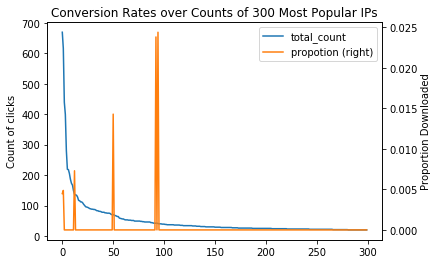

In [20]:
var = 'ip'
propotion = train_sample[[var, 'is_attributed']].groupby(var, as_index=False).mean()
propotion[var] = propotion[var].astype('uint32')
#propotion.info()
count = train_sample[[var, 'is_attributed']].groupby(var, as_index=False).count().sort_values('is_attributed', ascending=False).astype('uint32')
#count.info()
new = count.merge(propotion, on=var, how='left')
new.columns = ['ip', 'total_count', 'propotion']

ax = new.drop(var,axis=1)[:300].plot(secondary_y='propotion')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

No clear trend

# 5. Hourly click info

Text(0,0.5,'Number of clicks')

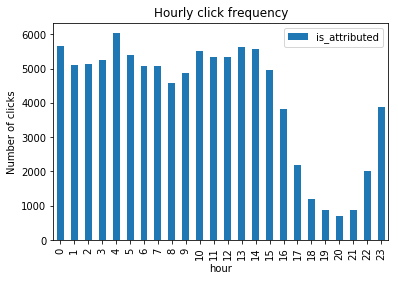

In [24]:
num_click_per_hour = train_sample[['hour','is_attributed']].groupby('hour', as_index=True).count()\
                     .plot(kind='bar')
plt.title("Hourly click frequency")
plt.ylabel("Number of clicks")

It seems that 0-14 is high frequency hour, 18-21 is low frequency hour and the rest is medium